# CLuster Anlysis for job role descriptions 

In [1]:
'''
1. Upload libraries 
'''
#EDA 
import numpy as np 
import pandas as pd
import os 
import re
import seaborn as sns
import matplotlib.pyplot as plt 

#Langauge detection 
import fasttext

#ML 
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#clustering 
from scipy.cluster.vq import kmeans, vq

#NLP
from sklearn.feature_extraction.text import CountVectorizer 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


#Warnigns
import warnings
warnings.filterwarnings("ignore")

#Setting up random states 
np.random.seed(42)

In [2]:
'''
2. Indicate the working directory file  
'''
PROJECT_ROOT_DIR = os.getcwd()


In [3]:
'''
3. Import data sources, web scrapping DB  
'''
BD_ofertas = pd.read_pickle(os.path.join(PROJECT_ROOT_DIR,"01_BD\\Ofertas\\BD_Ofertas.pkl"))

In [4]:
BD_ofertas.tail()

,Role,Role_location,Role_location_latitud,Role_location_longitud,Fecha_de_consulta,Fecha_de_postulacion,Fecha_Vencimiento,link_Aplicacion,Company,Role_Description,employmentType,JCI_Job_Type,JCI_Job_Function,jobBenefits,Role_Description_language,dia de postulación,duración de la oferta,Ofertas por tag
1629,Becario Business Operations Analyst / Internsh...,Madrid,40.48935,-3.68275,25-07-21,2021-07-22,2021-07-24,https://www.glassdoor.com/partner/jobListing.h...,Spin Fleet Operations,[],OTHER,NaN,NaN,NaN,sh,Miércoles,2,False
1630,BUSINESS ANALYST,Madrid,40.48935,-3.68275,25-07-21,2020-07-30,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,Canal UGR,['Titulaciones\nINGENIERÍA DE TELECOMUNICACION...,FULL_TIME,Full-time,Business Analyst,NaN,es,Miércoles,390,True
1631,Content Metadata Analyst,Madrid,40.48935,-3.68275,25-07-21,2021-07-20,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,WarnerMedia,['JOB DESCRIPTION\n\nHBO Max® is WarnerMedia’s...,FULL_TIME,Full-time,Analyst,"401K Plan, Health Insurance, Maternity & Pater...",en,Lunes,35,False
1632,Business Analyst - Zimit,Granada,37.18817,-3.60667,25-07-21,2021-06-17,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,NGA Human Resources,"['Job Summary\n\n\nThe Business Analyst, as pa...",FULL_TIME,Full-time,Business Analyst,"Health Insurance, 401K Plan, Vacation & Paid T...",en,Miércoles,68,True
1633,DATA BUSINESS ANALYST,Madrid,40.48935,-3.68275,25-07-21,2021-07-01,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,BNP Paribas,"[""Data Business Analyst – RISK AIR\nBNP Pariba...",FULL_TIME,Full-time,Business Analyst,"401K Plan, Maternity & Paternity Leave, Health...",en,Miércoles,54,True


In [5]:
'''
Language detection   
'''
model = fasttext.load_model('lid.176.ftz')

In [6]:
BD_ofertas["Role_Description_language"] = BD_ofertas["Role_Description"].apply(lambda x: model.predict(x, k=1)[0][0][-2:])
BD_ofertas["Role_Description_language"].value_counts()

en    1349
es     217
sh      64
fr       4
Name: Role_Description_language, dtype: int64

In [7]:
'''
Filter by english role only 
'''
BD_ofertas = BD_ofertas[BD_ofertas["Role_Description_language"] == "en"]
BD_ofertas["Role_Description_language"].value_counts()

en    1349
Name: Role_Description_language, dtype: int64

In [8]:
'''
As a preventive measure I shuffled the observations index, for avoiding correlations by position
caused by the append of the diferents data set. 
'''
BD_ofertas =sklearn.utils.shuffle(BD_ofertas)
BD_ofertas = BD_ofertas.reset_index(drop = True)
BD_ofertas.tail()

,Role,Role_location,Role_location_latitud,Role_location_longitud,Fecha_de_consulta,Fecha_de_postulacion,Fecha_Vencimiento,link_Aplicacion,Company,Role_Description,employmentType,JCI_Job_Type,JCI_Job_Function,jobBenefits,Role_Description_language,dia de postulación,duración de la oferta,Ofertas por tag
1344,Big Data Developer / Data Engineer,Madrid,40.48935,-3.68275,25-07-21,2021-06-29,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,Exceltic,['Responsibilities\n\nBig Data developer -Data...,FULL_TIME,Full-time,Data Engineer,NaN,en,Lunes,56,True
1345,Lead Data Engineer,Barcelona,41.39942,2.12804,25-07-21,2021-07-08,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,PayFit,"[""Who are we?\n\nPayFit simplifies payroll man...",FULL_TIME,Full-time,Data Engineer,NaN,en,Miércoles,47,True
1346,Practicas Marketing Cyber Analyst Madrid,Las Rozas de Madrid,40.49292,-3.87371,25-07-21,2021-06-29,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,Allot,['Who we are\nAllot is an established industry...,PART_TIME,Part-time,Information Security Analyst,NaN,en,Lunes,56,False
1347,Signature Support Engineer - English and Spani...,Madrid,40.48935,-3.68275,25-07-21,2021-07-02,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,Salesforce,"[""To get the best candidate experience, please...",FULL_TIME,Full-time,Support Engineer,"Health Insurance, 401K Plan, Vacation & Paid T...",en,Jueves,53,False
1348,Data Engineer Gijón,Gijón,43.54111,-5.66444,25-07-21,2021-07-03,2021-08-24,https://www.glassdoor.com/partner/jobListing.h...,Accenture,['About Accenture\nAccenture is a leading glob...,FULL_TIME,Full-time,Data Engineer,"Health Insurance, 401K Plan, Vacation & Paid T...",en,Viernes,52,True


In [9]:
BD_ofertas.dtypes

Role                                 object
Role_location                        object
Role_location_latitud               float64
Role_location_longitud              float64
Fecha_de_consulta                    object
Fecha_de_postulacion         datetime64[ns]
Fecha_Vencimiento            datetime64[ns]
link_Aplicacion                      object
Company                              object
Role_Description                     object
employmentType                       object
JCI_Job_Type                         object
JCI_Job_Function                     object
jobBenefits                          object
Role_Description_language            object
dia de postulación                   object
duración de la oferta                 int64
Ofertas por tag                        bool
dtype: object

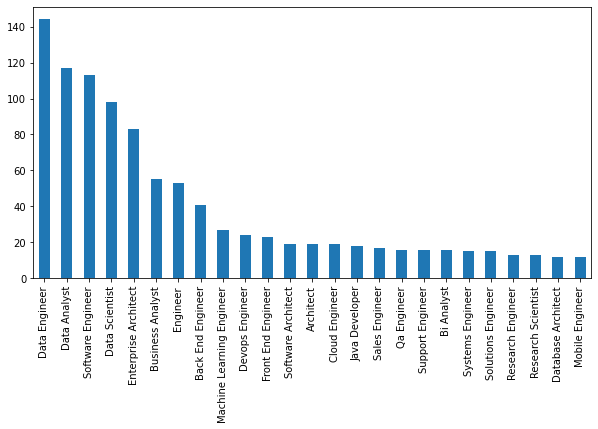

In [10]:
BD_ofertas["JCI_Job_Function"].value_counts()[:25].plot(kind='bar', figsize=(10,5));
plt.savefig("1")

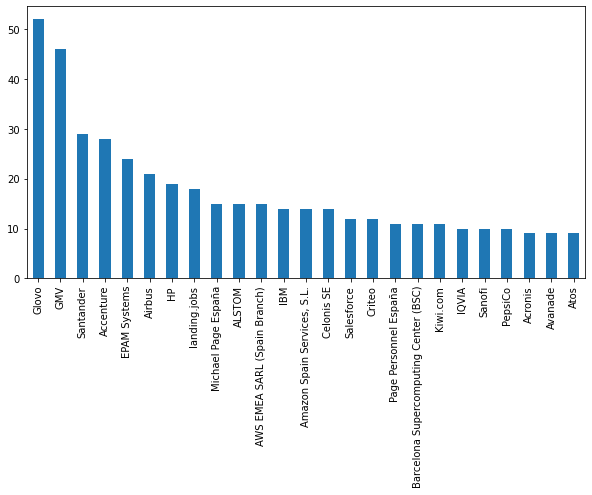

In [11]:
BD_ofertas["Company"].value_counts()[:25].plot(kind='bar', figsize=(10,5));
plt.savefig("2")

In [12]:
def clasifica_role(x):
    x = str.upper(x)
    
    if re.search(r'CIENT.FICO|DATA SCIEN|DATA SCIENCE',x):
        return "Data Scientist"
    
    elif re.search(r'BUSINES..*ANALYST|ANALISTA DE NEG.CIO.|BUSINEES..*ANALYST',x):
        return "Business Analyst"
    
    elif re.search(r'MACHINE LEARNING|ML|AI|MACHINE',x):
        return "ML Engineer"
    
    elif re.search(r'ARCHITECT',x):
        return "Data Architect"
    
    elif re.search(r'DATA ENGINEER|DATA MANAGER|BIG',x):
        return "Data Engineer"
    
    elif  re.search(r'BI|INTELLIGENCE',x):
        return "BI Analyst"
    
    elif  re.search(r'DATA ANALYST|ANALISTA DE DATOS|DATA ANALYTICS|DATA|DATA PROCESSING|ANALYST|ANALYTICS',x):
        return "Data Analyst"
    
    else:
        return "Evaluar"

BD_ofertas["role_data"] = BD_ofertas["JCI_Job_Function"].apply(clasifica_role)

BD_ofertas["role_data"].value_counts().sort_values(ascending=False).to_dict()

{'Evaluar': 618,
 'Data Analyst': 177,
 'Data Architect': 168,
 'Data Engineer': 145,
 'Data Scientist': 98,
 'Business Analyst': 55,
 'BI Analyst': 54,
 'ML Engineer': 34}

In [13]:
'''
Removing jobs that doesn't fit with the searches
'''
BD_ofertas = BD_ofertas[BD_ofertas["role_data"]!='Evaluar']

In [14]:
BD_ofertas["role_data"]

0       Data Architect
3       Data Architect
4        Data Engineer
6         Data Analyst
10      Data Architect
             ...      
1340      Data Analyst
1344     Data Engineer
1345     Data Engineer
1346      Data Analyst
1348     Data Engineer
Name: role_data, Length: 731, dtype: object

### Clustering 1 / Only taking care about role description 

#### 1. Preprocesing texts 

In [15]:
NP_byroles = BD_ofertas["Role_Description"]

In [16]:
NP_byroles = NP_byroles.reset_index(drop=True)

In [17]:
NP_byroles.head(50)

0     ["Introduction\nAs an IBM Application Architec...
1     ['HAYS Business Services is the Business Consu...
2     ["Internship agreement between university, com...
3     ["Introduction\nAs an IBM Application Architec...
4     ['MCF Solutions Architect - Senior Manager - J...
5     ["About Paack\nPaack is an avant-garde technol...
6     ["TeamCMP is a digital entertainment company f...
7     ['As a Microsoft Data & AI Technical Architect...
8     ['At Cognizant’s Digital Business – Artificial...
9     ["Are you ready to Playwork™ with us?\n\nYou w...
10    ['eDreams ODIGEO is one of the world’s largest...
11    ["As a Global Solution Architect, you are in a...
12    ['Ryanair Holdings plc, Europe’s largest airli...
13    ["At Guidewire, we deliver our platform as a c...
14    ["Our Mission at Allianz Technology is Leading...
15    ["We are the 100% digital bank of the Santande...
16    ['Background in any of the following: Cloud Ar...
17    ["About Glovo:\nWe're a Barcelona-based st

In [18]:
def remove_list(x):
    x = str(x)
    x = x.lower()
    return "".join(i for i in x[2:-2])

In [19]:
NP_byroles = NP_byroles.apply(lambda x: remove_list(str(x)))

In [20]:
NP_byroles

0      introduction\nas an ibm application architect,...
1      hays business services is the business consult...
2      internship agreement between university, compa...
3      introduction\nas an ibm application architect,...
4      mcf solutions architect - senior manager - job...
                             ...                        
726    join our team as a\ncrm data analyst\nmataró\n...
727    responsibilities\n\nbig data developer -data e...
728    who are we?\n\npayfit simplifies payroll manag...
729    who we are\nallot is an established industry l...
730    about accenture\naccenture is a leading global...
Name: Role_Description, Length: 731, dtype: object

In [21]:
NP_byroles_len = NP_byroles.apply(lambda x: len(x))

In [22]:
NP_byroles_len.sort_values(ascending = False)

245    9747
730    9330
236    9238
197    9206
18     8545
       ... 
408     533
587     509
636     487
710     458
147     178
Name: Role_Description, Length: 731, dtype: int64

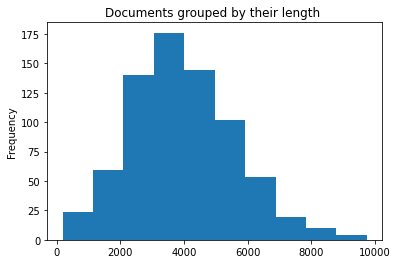

In [23]:
ax = NP_byroles_len.plot.hist(bins=10, title = "Documents grouped by their length ")
plt.savefig("3")

#### Removing Links 

In [24]:
def remove_links(df):
    return " ".join([' ' if ('http') in word else word for word in df.split()])

In [25]:
NP_byroles = NP_byroles.apply(remove_links)

In [26]:
NP_byroles

0      introduction\nas an ibm application architect,...
1      hays business services is the business consult...
2      internship agreement between university, compa...
3      introduction\nas an ibm application architect,...
4      mcf solutions architect - senior manager - job...
                             ...                        
726    join our team as a\ncrm data analyst\nmataró\n...
727    responsibilities\n\nbig data developer -data e...
728    who are we?\n\npayfit simplifies payroll manag...
729    who we are\nallot is an established industry l...
730    about accenture\naccenture is a leading global...
Name: Role_Description, Length: 731, dtype: object

#### Removing stop words 


In [27]:
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gahs_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
def remove_stopwords(df):
    english_stopwords = stopwords.words('english')
    
    extra_words = ['we','re','sexual','sex','you','ll','every day','gender identity','us','doud','equal opportunity','around world',
     'opportunity employer','gender','race','color','proud equal opportunity','religious','religion','marital','ibm','glovo'] 
    [english_stopwords.append(i) for i in extra_words]
    return " ".join([word for word in df.split() if word not in english_stopwords])

In [29]:
NP_byroles = NP_byroles.apply(remove_stopwords)

#### Removing companies name from corpus


In [30]:
organizations = BD_ofertas['Company'].tolist()

In [31]:
def eliminate_organization (df):
    organizations
    return " ".join([word for word in df.split() if word not in organizations])

In [32]:
NP_byroles = NP_byroles.apply(eliminate_organization)

#### Eliminating puntuation marks 

In [33]:
'''
Regex processing for eliminating any unnecessary character 
'''

REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)|(\\t)|(\®)|(\™)|(\™)|(\©)|(\&)|(\#)|(\_)")
REPLACE_NO_SPACE = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\\)|(\+)")

NO_SPACE = ""
SPACE = " "

def remove_symbols(a):
    a_clean = re.sub(r"\\n",' ',a) 
    a_clean = re.sub(r"[0-9]+","",a_clean) 
    a_clean = REPLACE_WITH_SPACE.sub(SPACE, a_clean)
    a_clean = REPLACE_NO_SPACE.sub(NO_SPACE, a_clean)
    return str(a_clean)

In [34]:
NP_byroles = NP_byroles.apply(lambda x: remove_symbols(str(x)))

In [35]:
'''
Reviewing 
'''

NP_byroles

0      introduction as application architect directly...
1      hays business services business consulting lin...
2      internship agreement university company studen...
3      introduction as application architect directly...
4      mcf solutions architect   senior manager   job...
                             ...                        
726    join team a crm data analyst mataró  are ready...
727    responsibilities  big data developer  data eng...
728    we  payfit simplifies payroll management hr pr...
729    are allot established industry leader network ...
730    accenture accenture leading global professiona...
Name: Role_Description, Length: 731, dtype: object

In [36]:
NP_byroles[0]

"introduction as application architect directly help clients transform business solve complex problems define scope vision projects deliver customized solutions using knowledge platforms technical leader serving liaison among business partners technical resources project stakeholders  your role responsibilities  within global business services focused business core banking transformation banking clients seeking senior architect core banking solution expertise join team spain role participate analyzing banking architecture banking clients legacy core banking applications surrounding systems defining target application architectures including new cloud native core banking systems migration strategies clients focus transforming core banking system cloud advise clients identify right technology strategy help modernize legacy applications mainframe well distributed build completely new application stack using modern cloud native architectures  responsibilities facilitate organizational chan

### Vectorization

In [37]:
cv   = CountVectorizer(min_df = 0.001)
cv   = cv.fit(NP_byroles)
X_cv = cv.transform(NP_byroles)

In [38]:
cv_N2   = CountVectorizer(ngram_range=(1, 2), min_df = 0.001)
cv_N2   = cv_N2.fit(NP_byroles)
X_cv_N2 = cv_N2.transform(NP_byroles)

In [39]:
cv_N3 = CountVectorizer(ngram_range=(1, 3),min_df = 0.001)
cv_N3 = cv_N3.fit(NP_byroles)
X_cv_N3 = cv_N3.transform(NP_byroles)

In [40]:
print("n1",X_cv.shape,"n2:",X_cv_N2.shape,"n3", X_cv_N3.shape)

n1 (731, 11481) n2: (731, 137574) n3 (731, 320478)


In [41]:
cv_df_n1_vecma = pd.DataFrame(X_cv.toarray(),columns=cv.get_feature_names())
cv_df_n1_vecma = cv_df_n1_vecma.reindex(sorted(cv_df_n1_vecma.columns), axis=1)

In [42]:
cv_df_n2_vecma = pd.DataFrame(X_cv_N2.toarray(),columns=cv_N2.get_feature_names())
cv_df_n2_vecma = cv_df_n2_vecma.reindex(sorted(cv_df_n2_vecma.columns), axis=1)

In [43]:
display(cv_df_n2_vecma)

,aa,aa adobe,aa disabled,aa goal,aags,aags support,aai,aai eu,aai europe,aaron,...,álvarez,álvarez charge,ético,ético leal,éxito,éxito de,üs,üs umlaut,сommunicate,сommunicate product
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
NP_byroles[cv_df_n2_vecma["aa adobe"] ==1 ]

338    company description  at netcentric come work e...
Name: Role_Description, dtype: object

In [45]:
'''
Review strange values in corpus identified at the vector count matrix
'''
NP_byroles.iloc[338]

'company description  at netcentric come work every day knowing we’re part solution complex challenges brands ever faced digital transformation consumer expectation brands increasing world connected fast paced netcentric dynamic innovative service provider unique culture empower employees use creativity looking beyond tools technology unlock full potential adobe experience cloud deliver visionary digital marketing solutions world’s recognized brands as part cognizant digital business reap benefits combined expertise access multidisciplinary teams forging ahead become leading customer experience player europe our teams based world’s exciting cities   zurich munich berlin frankfurt dresden barcelona bucharest london amsterdam offices find culture embraces  different nationalities and oh mention empower employees make meaningful decisions work holacracy  job description  we growing requirements engineering   business analyst team barcelona vigo looking new colleagues bring consultative an

In [46]:
'''
Evaluating the code to add word frecuency to a data frame
'''
X_cv.sum(axis=0).reshape(X_cv.shape[1])

matrix([[3, 1, 5, ..., 1, 2, 2]], dtype=int64)

In [47]:
'''
generating data frame for each n_gram corpus
'''

cv_df_n1 = pd.DataFrame(X_cv.toarray().sum(axis=0), index = cv.get_feature_names(), columns = ['count'])
cv_df_n2 = pd.DataFrame(X_cv_N2.toarray().sum(axis=0), index = cv_N2.get_feature_names(), columns = ['count'])
cv_df_n3 = pd.DataFrame(X_cv_N3.toarray().sum(axis=0), index = cv_N3.get_feature_names(), columns = ['count'])

cv_df_n1 = cv_df_n1.sort_values(by='count', ascending=False)
cv_df_n2 = cv_df_n2.sort_values(by='count', ascending=False)
cv_df_n3 = cv_df_n3.sort_values(by='count', ascending=False)

In [48]:
'''
For better plotting ngrams corpus,I generated addicional 2 count vectors   
'''
cv_N2_graph  = CountVectorizer(ngram_range=(2, 2), min_df = 0.001)
cv_N2_graph   = cv_N2_graph.fit(NP_byroles)
X_cv_N2_graph = cv_N2_graph.transform(NP_byroles)
cv_df_n2_graph = pd.DataFrame(X_cv_N2_graph.toarray().sum(axis=0), index = cv_N2_graph.get_feature_names(), columns = ['count'])
cv_df_n2_graph = cv_df_n2_graph.sort_values(by='count', ascending=False)


In [49]:
cv_N3_graph  = CountVectorizer(ngram_range=(3, 3), min_df = 0.001)
cv_N3_graph   = cv_N3_graph.fit(NP_byroles)
X_cv_N3_graph = cv_N3_graph.transform(NP_byroles)
cv_df_n3_graph = pd.DataFrame(X_cv_N3_graph.toarray().sum(axis=0), index = cv_N3_graph.get_feature_names(), columns = ['count'])
cv_df_n3_graph = cv_df_n3_graph.sort_values(by='count', ascending=False)

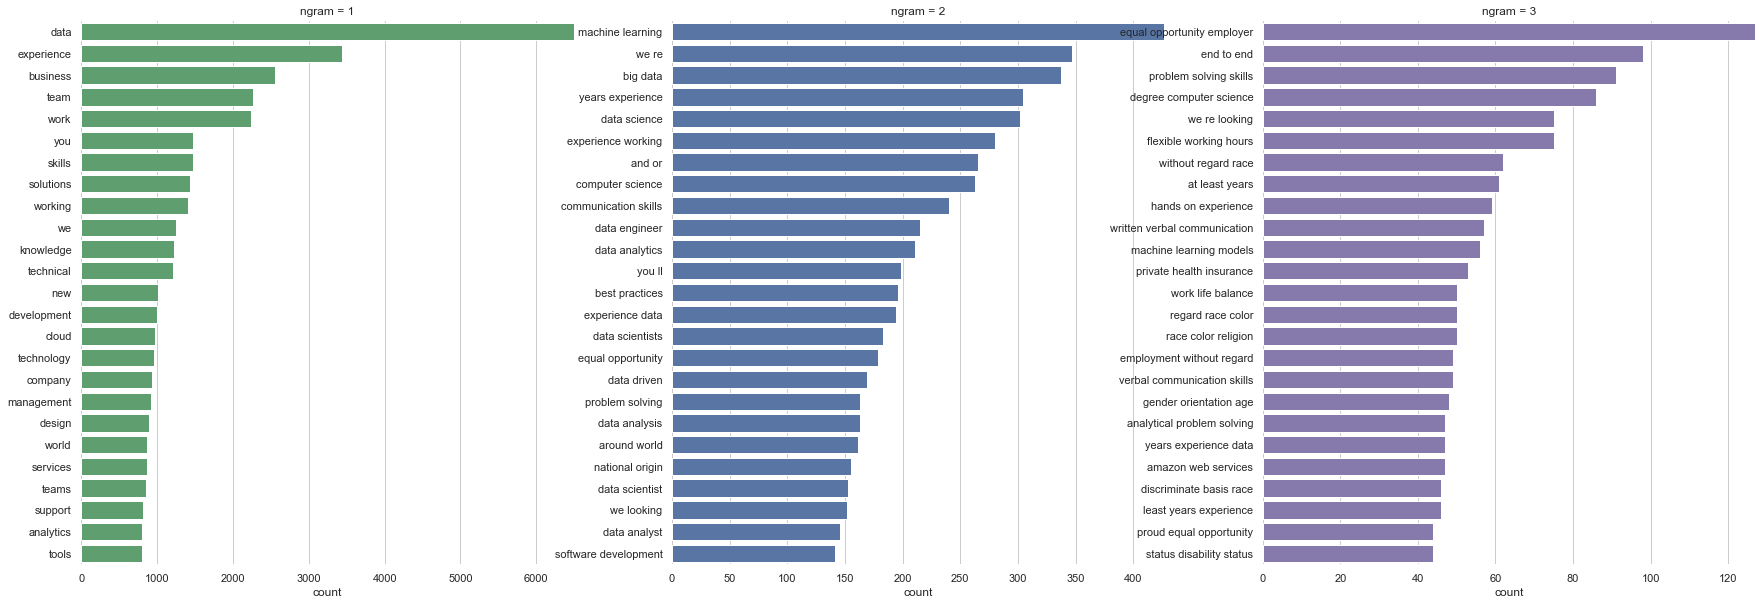

In [50]:
sns.set_theme(style="whitegrid")
# Initialize the matplotlib figure
f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(30,10))
#f.subtitle('Token frequency by ngram ')
f = sns.barplot(x="count", y=cv_df_n1.index.tolist()[0:25] , data=cv_df_n1[0:25], color="g",ax =ax)
ax.set_title("ngram = 1")
ax.set_xlim(max(cv_df_n1[0:25].values)*0.0,max(cv_df_n1[0:25].values))

sns.barplot(x="count", y=cv_df_n2_graph.index.tolist()[0:25] , data=cv_df_n2_graph[0:25], color="b",ax =ax2)
ax2.set_title("ngram = 2")
ax2.set_xlim(max(cv_df_n2_graph[0:25].values)*0.0,max(cv_df_n2_graph[0:25].values))

sns.barplot(x="count", y=cv_df_n3_graph.index.tolist()[0:25] , data=cv_df_n3_graph[0:25], color="m",ax =ax3)
ax3.set_title("ngram = 3")
ax3.set_xlim(max(cv_df_n3_graph[0:25].values)*0.0,max(cv_df_n3_graph[0:25].values)) 

#Add a legend and informative axis label
sns.despine(left=True, bottom=True);
plt.savefig("3")

### Understanding why it has words in other lenguagues

In [51]:
cv_df_n1_vecma

,aa,aags,aai,aaron,aas,ab,abb,abengoa,abilities,ability,...,zos,zubiaurre,zuora,zurich,zürich,álvarez,ético,éxito,üs,сommunicate
0,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
729,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
cv_df_n1_vecma['éxito'].sum()

1

In [53]:
exito = cv_df_n1_vecma['éxito'] > 0
exito = exito.values.reshape(exito.shape[0])
exito

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [54]:
NP_byroles[exito]

319    bip es una consultora internacional especializ...
Name: Role_Description, dtype: object

In [55]:
NP_byroles[319]

"bip es una consultora internacional especializada desde su fundación en  en facilitar la transformación end to end de los negocios de sus clientes donde “hacemos que las cosas ocurran” definiendo operativizando e implantando estrategias de crecimiento transformación digital eficiencia operacional la clave del éxito de bip es simple el afán por un servicio excelente con un enfoque ético leal hacia nuestros clientes diseñando soluciones innovadoras desarrollando productos servicios de vanguardia con sede en milán más de  profesionales bip tiene oficinas en más de  países asesora sus clientes en más de  contamos con equipos especialistas en las principales industrias energía e infraestructuras sector financiero sanidad industria sector público retail telecomunicaciones medios de comunicación entretenimiento  data scientist do want part tech revolution  so join bip   xtech center excellence focused innovation consulting services concerning advanced analytics data science big data rpa netw

#### Stemming

In [56]:
from nltk.stem.porter import PorterStemmer

In [57]:
def get_stemmed_text(corpus):
    stemmer = PorterStemmer() 
    return " ".join([stemmer.stem(word) for word in corpus.split()])
        
NP_byroles_stemmed = NP_byroles.apply(get_stemmed_text) 

In [58]:
cv_stemmed_n1 = CountVectorizer(min_df = 0.001)
cv_stemmed_n1.fit(NP_byroles_stemmed)
X_cv_stemmed_n1 = cv_stemmed_n1.transform(NP_byroles_stemmed)

In [59]:
cv_stemmed_n2 = CountVectorizer(ngram_range=(1, 2), min_df = 0.001)
cv_stemmed_n2.fit(NP_byroles_stemmed)
X_cv_stemmed_n2 = cv_stemmed_n2.transform(NP_byroles_stemmed)

In [60]:
cv_stemmed_n3 = CountVectorizer(ngram_range=(1, 3), min_df = 0.001)
cv_stemmed_n3.fit(NP_byroles_stemmed)
X_cv_stemmed_n3 = cv_stemmed_n3.transform(NP_byroles_stemmed)

In [61]:
X_cv_stemmed_n3.shape[1]

297517

#### Lemmatizer

In [62]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_lemmatizer(corpus):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in corpus.split()])
        
NP_byroles_lemmatizer = NP_byroles.apply(get_lemmatizer) 

In [63]:
cv_lemma_n1   = CountVectorizer(min_df = 0.001)
cv_lemma_n1.fit(NP_byroles_lemmatizer)
X_cv_lemma_n1 = cv_lemma_n1.transform(NP_byroles_lemmatizer)

In [64]:
cv_lemma_n2 = CountVectorizer(ngram_range=(1, 2), min_df = 0.001)
cv_lemma_n2.fit(NP_byroles_lemmatizer)
X_cv_lemma_n2 = cv_lemma_n2.transform(NP_byroles_lemmatizer)

In [65]:
cv_lemma_n3 = CountVectorizer(ngram_range=(1, 3), min_df = 0.001)
cv_lemma_n3.fit(NP_byroles_lemmatizer)
X_cv_lemma_n3 = cv_lemma_n3.transform(NP_byroles_lemmatizer)

#### Corpus 

In [66]:
NP_byroles[0:11]

0     introduction as application architect directly...
1     hays business services business consulting lin...
2     internship agreement university company studen...
3     introduction as application architect directly...
4     mcf solutions architect   senior manager   job...
5     paack paack avant garde technology start up lo...
6     teamcmp digital entertainment company founded ...
7     microsoft data   ai technical architect aligne...
8     cognizant’s digital business – artificial inte...
9     ready playwork  us  you part team responsible ...
10    edreams odigeo one world’s largest online trav...
Name: Role_Description, dtype: object

In [67]:
NP_byroles_stemmed[0:11]

0     introduct as applic architect directli help cl...
1     hay busi servic busi consult line hay group ha...
2     internship agreement univers compani student f...
3     introduct as applic architect directli help cl...
4     mcf solut architect senior manag job descript ...
5     paack paack avant gard technolog start up logi...
6     teamcmp digit entertain compani found rochest ...
7     microsoft data ai technic architect align glob...
8     cognizant’ digit busi – artifici intellig anal...
9     readi playwork us you part team respons improv...
10    edream odigeo one world’ largest onlin travel ...
Name: Role_Description, dtype: object

In [68]:
NP_byroles_lemmatizer[0:11]

0     introduction a application architect directly ...
1     hay business service business consulting line ...
2     internship agreement university company studen...
3     introduction a application architect directly ...
4     mcf solution architect senior manager job desc...
5     paack paack avant garde technology start up lo...
6     teamcmp digital entertainment company founded ...
7     microsoft data ai technical architect aligned ...
8     cognizant’s digital business – artificial inte...
9     ready playwork u you part team responsible imp...
10    edreams odigeo one world’s largest online trav...
Name: Role_Description, dtype: object

In [69]:
dict_corpus = {'VC':[X_cv.shape[1],X_cv_N2.shape[1],X_cv_N3.shape[1]],
              'Stemming':[X_cv_stemmed_n1.shape[1],X_cv_stemmed_n2.shape[1], X_cv_stemmed_n3.shape[1]],
              'Lemmatizer':[X_cv_lemma_n1.shape[1],X_cv_lemma_n2.shape[1], X_cv_lemma_n3.shape[1]]
              }
df_corpus = pd.DataFrame(data= dict_corpus,index=['N1','N2','N3']) 
df_corpus

,VC,Stemming,Lemmatizer
N1,11481,7820,10263
N2,137574,118370,130555
N3,320478,297517,311591


In [70]:
'''
I choose lematizzer as a corpus cause reduce more features than count vector but not as the stemmer 
'''
NP_byroles = NP_byroles_lemmatizer 

#### TFIDF

In [71]:
'''
it isn't requerired cause before the vectorization process
'''
from nltk.tokenize import word_tokenize

def remove_noise(corpus):
    tokens = word_tokenize(corpus)  
    corpus = remove_links(corpus)
    corpus = remove_symbols(corpus)
    corpus = remove_stopwords(corpus)
    #corpus = get_stemmed_text(corpus)
    return corpus


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=None, analyzer='word', ngram_range=(1, 3))
tfidf_matrix = tfidf_vectorizer.fit_transform(NP_byroles)


In [73]:
tfidf_vectorizer.vocabulary_

{'introduction': 147240,
 'application': 15786,
 'architect': 17880,
 'directly': 83136,
 'help': 128651,
 'client': 43675,
 'transform': 287171,
 'business': 34657,
 'solve': 256286,
 'complex': 52101,
 'problem': 212304,
 'define': 72892,
 'scope': 243555,
 'vision': 297429,
 'project': 218026,
 'deliver': 73920,
 'customized': 64296,
 'solution': 254224,
 'using': 293945,
 'knowledge': 152514,
 'platform': 204267,
 'technical': 275948,
 'leader': 156538,
 'serving': 248188,
 'liaison': 160026,
 'among': 10692,
 'partner': 197694,
 'resource': 234346,
 'stakeholder': 260914,
 'your': 311104,
 'role': 238201,
 'responsibility': 234787,
 'within': 303027,
 'global': 121786,
 'service': 246865,
 'focused': 114596,
 'core': 58340,
 'banking': 26312,
 'transformation': 287271,
 'seeking': 245402,
 'senior': 246097,
 'expertise': 108037,
 'join': 150062,
 'spain': 257669,
 'participate': 197319,
 'analyzing': 14118,
 'architecture': 18678,
 'legacy': 158785,
 'surrounding': 269058,
 'syste

#### Clusterization 

In [ ]:
distorsions = []
cluster_centers_array = []
num_clusters = range(2,8)

for i in num_clusters:
    cluster_centers, distortion = kmeans(tfidf_matrix.todense(),i)
    distorsions.append(distortion)
    cluster_centers_array.append(cluster_centers)

In [ ]:
terms = tfidf_vectorizer.get_feature_names()
for i in num_clusters:
    center_terms = dict(zip(terms,list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get,reverse=True)
    print(sorted_terms[:10])

In [ ]:
elbow_plot = pd.DataFrame({"num_clusters":num_clusters,
                          'distorsions':distorsions
                          })

sns.lineplot(x='num_clusters', y='distorsions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()
plt.savefig("3")

#### Visualizating Clusterization by PCA 

from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tfidf_matrix.todense())
test_e = KMeans(n_clusters = 3,random_state =42, max_iter = 600)
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);
fig = plt.gcf()
fig.set_size_inches(15, 8)
fig.savefig('cluster_tfidf', dpi=300)
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.legend(fontsize=10)

In [ ]:
fitted.score

In [ ]:
NP_byroles["role_data"] = BD_ofertas["role_data"]
roles = pd.unique(NP_byroles["role_data"])
#colors = ['b','g','r','c','m','y','k','w']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
          'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

for i,j in enumerate(roles):
    mask = NP_byroles["role_data"] == j
    color=colors[i]
    plt.scatter(Y_sklearn[mask][:, 0], Y_sklearn[mask][:, 1], c=color,label = j, s=50, cmap='viridis')
fig = plt.gcf()
fig.set_size_inches(15, 8)
fig.savefig('cluster_byrole', dpi=300)
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.legend(fontsize=10);

Visualizating Clusterization by Dendogram

In [ ]:
from sklearn.datasets import make_moons

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit()



In [ ]:
from sklearn.cluster import DBSCAN, MeanShift, OPTICS
from sklearn.metrics.pairwise import cosine_distances

# Define clustering algorithms
algorithms = [DBSCAN, MeanShift, OPTICS]

# Placeholder for results
results = dict.fromkeys((a.__name__ for a in algorithms))

# Fit each clustering algorithm and store results
for algorithm in algorithms:
    results[algorithm] = algorithm(metric=cosine_distances).fit(tfidf_matrix)

Exporting Model 

In [ ]:
grid_search.fit(df['Content'],df['Polarity'])

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)a

In [ ]:
import pickle

with open('finished_model.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)